# Create Scan CSV files

In [2]:
import pandas as pd
import os
from gensim import utils
import numpy as np

datadir = './data/'


In [2]:
# !python -m pip install -U gensim

#### SCAN Approach #1: unchanged dataset

In [4]:
# standard layout, domain (a, b) -> subdomain (c, d)
# load and save :p
with open(os.path.join(datadir, 'SCAN/SCAN_dataset.csv'), 'r', encoding='utf8') as f:
    df = pd.read_csv(f, sep=',', index_col=False)

filename = 'scan_default.csv'
loc = os.path.join(datadir, filename)
if not os.path.exists(loc):
    df.to_csv(loc)
    print(f'created {filename} at {loc}')
else:
    print('file already exists:', filename)

file already exists: scan_default.csv


<AxesSubplot: >

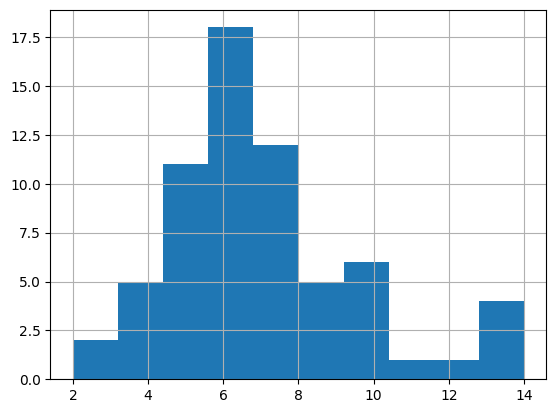

In [16]:
# histogram of items per domain (category) 
df.groupby(['target', 'source']).count().analogy_type.hist()

##### Scan Approach #2: inverted

In [4]:
# use the reversed c, d -> a, b
a, b, c, d, *e = df.columns
inverse_df = df[[c, d, a, b, *e]]
# all alternatives should be none
inverse_df.alternatives = None


In [5]:
filename = 'scan_inverse.csv'
loc = os.path.join(datadir, filename)
if not os.path.exists(loc):
    inverse_df.to_csv(loc)
    print(f'created {filename} at {loc}')
else:
    print('file already exists:', filename)

created scan_inverse.csv at ./data/scan_inverse.csv


#### SCAN Approach #3: domain comparison

In [6]:
# domain comparisons dataframe

print(df.groupby(['target', 'source']).first().analogy_type.value_counts())
print(f'For domain comparison we expect 54*53={54*53} metaphor rows and 11*10=110 science rows')

metaphor    54
science     11
Name: analogy_type, dtype: int64
For domain comparison we expect 54*53=2862 metaphor rows and 11*10=110 science rows


In [7]:
groups = df.groupby(['target', 'source', 'analogy_type'])
rows = []
for *ab, a_t1 in groups.groups.keys():
    for *cd, a_t2 in groups.groups.keys():
        # print(a_t1, a_t2)
        if a_t1 == a_t2:
            # print(cd)
            if ab != cd:
                rows.append([*ab, *cd, None, a_t1])
# rows
domain_df = pd.DataFrame(rows, columns=df.columns, dtype='object') 
domain_df.analogy_type.value_counts()

metaphor    2862
science      110
Name: analogy_type, dtype: int64

In [8]:
domain_df.head()

,target,source,targ_word,src_word,alternatives,analogy_type
0,accepting a belief,buying an item,ambition,hunger,None,metaphor
1,accepting a belief,buying an item,argument,war,None,metaphor
2,accepting a belief,buying an item,business,hunt,None,metaphor
3,accepting a belief,buying an item,business,war,None,metaphor
4,accepting a belief,buying an item,career,hill,None,metaphor


In [9]:
filename = 'scan_domains.csv'
loc = os.path.join(datadir, filename)
if not os.path.exists(loc):
    domain_df.to_csv(loc)
    print(f'created {filename} at {loc}')
else:
    print('file already exists:', filename)

created scan_domains.csv at ./data/scan_domains.csv


#### SCAN Approach #4: random sample

In [40]:
# number of samples n
n = 2

# create dataframe
rows = []
groups = df.groupby(['target', 'source'])

for group_header, items in groups:
    indices = np.arange(len(items))
    if n > len(items):
        n = len(items)
    random_picks = np.random.choice(indices, n, replace=False)
    # create n rows per group
    for pick_idx in random_picks:
        rand_row = items.iloc[pick_idx, [2,3]]
        rand_category = items.iloc[pick_idx, 5]
        rows.append([*group_header, *rand_row, None, rand_category])


scan_sampled = pd.DataFrame(rows, columns=df.columns)
scan_sampled

,target,source,targ_word,src_word,alternatives,analogy_type
0,accepting a belief,buying an item,belief,merchandise,None,metaphor
1,accepting a belief,buying an item,true,valuable,None,metaphor
2,ambition,hunger,complacency,satiation,None,metaphor
3,ambition,hunger,nourishment,food,None,metaphor
4,argument,war,claim,position,None,metaphor
...,...,...,...,...,...,...
125,time,money,quick,cheap,None,metaphor
126,understanding,following,listener,follower,None,metaphor
127,understanding,following,complicated,twisted,None,metaphor
128,understanding,seeing,interpretation,view,None,metaphor


In [41]:
# write to csv
filename = f'scan_sampled_{n}.csv'
loc = os.path.join(datadir, filename)
if not os.path.exists(loc):
    scan_sampled.to_csv(loc)
    print(f'created {filename} at {loc}')
else:
    print('file already exists:', filename)

created scan_sampled_2.csv at ./data/scan_sampled_2.csv


# Create BATS CSV files

In [3]:
names = []
pairs_sets = []
dir = "data/BATS_3.0"

for d in os.listdir(dir):
    if d != 'metadata.json':
        for f in os.listdir(os.path.join(dir,str(d))):
            names.append(str(f)[:-4])
            pairs_sets.append(set())
            with utils.open_file(os.path.join(dir,str(d),str(f))) as fin:
                for line_no, line in enumerate(fin):
                    line = utils.to_unicode(line)
                    a, b = [word.lower() for word in line.split()]
                    list_b = b.split('/')
                    if list_b[0] != a: #Keeping only the first analogy pair
                        pairs_sets[-1].add((a, list_b[0]))
vocab_bats = (names, pairs_sets)


####  BATS Approach #1: all combinations

In [11]:
# analyze expected items
names, cats = vocab_bats
lengths = [len(c) for c in cats]
nitems_df = pd.DataFrame(zip(names, lengths), columns=['category', 'n_items'])
nitems_df['expected items'] = nitems_df.n_items * (nitems_df.n_items - 1)
print('Total expected rows:', nitems_df['expected items'].sum())
nitems_df

Total expected rows: 97806


,category,n_items,expected items
0,I01 [noun - plural_reg],50,2450
1,I02 [noun - plural_irreg],48,2256
2,I03 [adj - comparative],50,2450
3,I04 [adj - superlative],50,2450
4,I05 [verb_inf - 3pSg],50,2450
5,I06 [verb_inf - Ving],50,2450
6,I07 [verb_inf - Ved],50,2450
7,I08 [verb_Ving - 3pSg],50,2450
8,I09 [verb_Ving - Ved],50,2450
9,I10 [verb_3pSg - Ved],50,2450


In [12]:
#  create dataframe
rows = []
categories, lists = vocab_bats
for category, clist in zip(categories, lists):
    for row1 in clist:
        for row2 in clist:
            if row1 != row2:
                rows.append([*row1, *row2, None, category])
bats_all_combis_df = pd.DataFrame(rows, columns=df.columns)
bats_all_combis_df

,target,source,targ_word,src_word,alternatives,analogy_type
0,song,songs,year,years,None,I01 [noun - plural_reg]
1,song,songs,customer,customers,None,I01 [noun - plural_reg]
2,song,songs,example,examples,None,I01 [noun - plural_reg]
3,song,songs,version,versions,None,I01 [noun - plural_reg]
4,song,songs,week,weeks,None,I01 [noun - plural_reg]
...,...,...,...,...,...,...
97801,in,out,beginning,end,None,L10 [antonyms - binary]
97802,in,out,dive,emerge,None,L10 [antonyms - binary]
97803,in,out,under,over,None,L10 [antonyms - binary]
97804,in,out,first,last,None,L10 [antonyms - binary]


In [13]:
# check if number of items per category are as expected
tdf = nitems_df.set_index('category')
tdf.index.names = [None]
bats_all_combis_df.analogy_type.value_counts().sort_values().all() == tdf["expected items"].sort_values().all()

True

In [14]:
filename = 'bats_allcombinations.csv'
loc = os.path.join(datadir, filename)
if not os.path.exists(loc):
    bats_all_combis_df.to_csv(loc)
    print(f'created {filename} at {loc}')
else:
    print('file already exists:', filename)

created bats_allcombinations.csv at ./data/bats_allcombinations.csv


####  BATS Approach #2: take target from next line

word pairs within each category
```
(a, b)
(c, d)
(e, f)
(g, h)
```
are converted to 
```
a, b, c, d
c, d, e, f
e, f, g, h
```


In [15]:
categories, pairs = vocab_bats
rows = []
for c, p in zip(categories, pairs):
    for pair_idx in range(len(p)-1):
        pairlist = list(p)
        wordpair1 = pairlist[pair_idx]
        wordpair2 = pairlist[pair_idx+1]
        rows.append([*wordpair1, *wordpair2, None, c])
bats_nextline = pd.DataFrame(rows, columns=df.columns)
bats_nextline

,target,source,targ_word,src_word,alternatives,analogy_type
0,song,songs,year,years,None,I01 [noun - plural_reg]
1,year,years,customer,customers,None,I01 [noun - plural_reg]
2,customer,customers,example,examples,None,I01 [noun - plural_reg]
3,example,examples,version,versions,None,I01 [noun - plural_reg]
4,version,versions,week,weeks,None,I01 [noun - plural_reg]
...,...,...,...,...,...,...
1953,beginning,end,dive,emerge,None,L10 [antonyms - binary]
1954,dive,emerge,under,over,None,L10 [antonyms - binary]
1955,under,over,first,last,None,L10 [antonyms - binary]
1956,first,last,internal,external,None,L10 [antonyms - binary]


In [16]:
filename = 'bats_target_nextline.csv'
loc = os.path.join(datadir, filename)
if not os.path.exists(loc):
    bats_nextline.to_csv(loc)
    print(f'created {filename} at {loc}')
else:
    print('file already exists:', filename)

created bats_target_nextline.csv at ./data/bats_target_nextline.csv


#### Not used: BATS Approach #3 take target from next line and remove the next line

word pairs within each category
```
(a, b)
(c, d)
(e, f)
(g, h)
```
are converted to 
```
a, b, c, d
e, f, g, h
```


In [17]:
# or use shift to have 1000 rows
# [pd.DataFrame(zip(list(c), n*len(c)), columns=['source', 'target', 'category']) for n, c in zip(names, categories)]
# category_dfs = [pd.DataFrame(list(vocab_bats[1][ctype_idx])+ [vocab_bats[0][ctype_idx]]*len(list(vocab_bats[1][ctype_idx])), columns=['source', 'target', 'category']) for ctype_idx in range(len(vocab_bats[1]))]
# collapsed_dfs =  [pd.concat([df, df.shift(-1)['source', 'target']], axis=1).iloc[::2] for df in category_dfs]
# df = pd.concat(collapsed_dfs, axis=0).reset_index(drop=True) 

#### BATS Approach #4: Random sample 
Sample n other example word pairs for each word pair in a category

In [19]:
# number of samples n, cannot be larger than length of smallest pairlist which is 48
n = 5

# create dataframe
rows = []
categories, lists = vocab_bats
for category, catpairs in zip(categories, lists):
    pairlist = list(catpairs)
    indices = np.arange(len(pairlist))
    if n > len(pairlist):
        n = len(pairlist)
    for row_idx in indices:
        # sample n different indices
        other_indices = np.delete(indices, row_idx)
        random_picks = np.random.choice(indices, n, replace=False)
        # create n rows 
        for pick_idx in random_picks:
            row = pairlist[row_idx]
            rand_row = pairlist[pick_idx]
            rows.append([*row, *rand_row, None, category])
bats_sampled = pd.DataFrame(rows, columns=df.columns)
bats_sampled


,target,source,targ_word,src_word,alternatives,analogy_type
0,science,sciences,road,roads,None,I01 [noun - plural_reg]
1,science,sciences,problem,problems,None,I01 [noun - plural_reg]
2,science,sciences,role,roles,None,I01 [noun - plural_reg]
3,science,sciences,idea,ideas,None,I01 [noun - plural_reg]
4,science,sciences,solution,solutions,None,I01 [noun - plural_reg]
...,...,...,...,...,...,...
9985,downslope,upslope,inside,outside,None,L10 [antonyms - binary]
9986,downslope,upslope,beginning,end,None,L10 [antonyms - binary]
9987,downslope,upslope,employ,dismiss,None,L10 [antonyms - binary]
9988,downslope,upslope,dead,alive,None,L10 [antonyms - binary]


In [19]:
filename = f'bats_sampled_{n}.csv'
loc = os.path.join(datadir, filename)
if not os.path.exists(loc):
    bats_sampled.to_csv(loc)
    print(f'created {filename} at {loc}')
else:
    print('file already exists:', filename)

created bats_sampled_5.csv at ./data/bats_sampled_5.csv
